In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint,loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [9]:
def load_csv(file_path):
    data_set = pd.read_csv(file_path)
    return data_set

def feature_engineering(data_set):
      
    return data_set

def split_data(data_set):   
    target_data = data_set['Credit Score'].copy()
    data_set = data_set.drop(columns=['Credit Score'])
        
    X_train, X_test, Y_train, Y_test = train_test_split(data_set,target_data,
                                                        test_size=0.2, 
                                                        random_state=42,
                                                        stratify=target_data)
    return X_train, X_test, Y_train, Y_test
        
    


def class_weights(Y_data):
    class_weight = compute_class_weight(class_weight='balanced',classes = np.unique(Y_data),y=Y_data)
    class_weight_dict = dict(enumerate(class_weight))
    print("Class weights computed")

from sklearn.calibration import CalibratedClassifierCV

def train_model(model="rf", class_weight_dict=None):
    if model == "rf":
        model = RandomForestClassifier(
            n_estimators=221, max_depth=None,
            criterion='log_loss', min_samples_split=8,
            min_samples_leaf=1, max_features='sqrt',
            bootstrap=True, ccp_alpha=0.0, random_state=42,
            class_weight=class_weight_dict, warm_start=True)
    elif model == "dt":
        model = DecisionTreeClassifier(
            random_state=42, max_depth=None,
            min_samples_split=2, criterion='log_loss',
            splitter='best', min_samples_leaf=1,
            class_weight=class_weight_dict)
    elif model == "svc":
        model = SVC(
            kernel='rbf', C=1.0, gamma='scale', probability=True,
            class_weight=class_weight_dict, random_state=42)
    elif model == "sgd":
        base_model = SGDClassifier(
            random_state=42, loss="hinge", penalty="l2", max_iter=1000,
            tol=1e-3, alpha=0.00001, learning_rate="optimal",
            eta0=0.0, power_t=0.5, early_stopping=True)
        model = CalibratedClassifierCV(base_model)  # <-- Add this line
    else:
        raise ValueError("Unsupported model type. Choose from 'rf', 'dt', 'svc', or 'sgd'.")
    return model

In [10]:
def cross_validation(model=None,X_train=None, Y_train=None, cv=5):
    
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1': make_scorer(f1_score, average='weighted')}
    
    scores = cross_validate(model,X_train,Y_train,scoring=scoring,
                         cv=25,error_score='raise',n_jobs=-1,verbose=1)
    scores_list = pd.DataFrame(scores)
    scores_mean = scores_list.mean(axis=0)
    return scores_mean

In [11]:

def hyparameter_tuning(model_pipeline, X_train, Y_train,cv=5,class_weight_dict=None):
    
    param_dict = {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 5),
        'classifier__max_features': ['sqrt', 'log2', 0.3],
        'classifier__ccp_alpha': [0.0, 0.01, 0.1],
        'classifier__bootstrap': [True, False],
        'classifier__class_weight': [class_weight_dict, None],
        'classifier__criterion': ['gini', 'entropy', 'log_loss'],
        'classifier__warm_start': [True, False],
        'classifier__n_estimators': randint(100, 300),
    }
    
    # Perform RandomizedSearchCV with SVC-specific parameters
    random_search = RandomizedSearchCV(estimator=model_pipeline, param_distributions=param_dict, n_iter=10,
                                    scoring='accuracy', cv=cv, verbose=1, random_state=42, n_jobs=-1)
    random_search.fit(X_train, Y_train)
    return print(random_search.best_params_, random_search.best_score_)
    

In [12]:
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, X_train, Y_train, label=None):
    # Binarize the output for multiclass
    classes = np.unique(Y_train)
    Y_train_bin = label_binarize(Y_train, classes=classes)
    n_classes = Y_train_bin.shape[1]

    prd_scores = cross_val_predict(model, X_train, Y_train, cv=5, method='predict_proba')

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(Y_train_bin[:, i], prd_scores[:, i])
        plt.plot(fpr, tpr, label=f'Class {classes[i]}')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend()
    plt.show()
    

Fitting model pipeline...
     Age  Gender  Income            Education Marital Status  \
72    51    Male  145000    Bachelor's Degree        Married   
138   40    Male  130000  High School Diploma         Single   
94    30    Male  117500      Master's Degree        Married   
12    27  Female   35000  High School Diploma         Single   
135   25  Female   55000    Bachelor's Degree         Single   
..   ...     ...     ...                  ...            ...   
114   43    Male   95000      Master's Degree         Single   
107   37  Female   77500    Bachelor's Degree        Married   
6     26  Female   40000   Associate's Degree         Single   
109   47  Female   97500            Doctorate        Married   
106   32    Male   57500   Associate's Degree         Single   

     Number of Children Home Ownership  
72                    0          Owned  
138                   0          Owned  
94                    2          Owned  
12                    0         Rented  


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 12 members, which is less than n_splits=25.
  warnings.warn(
/opt/anaconda3/envs/aiml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.6min finished


fit_time          9.285251
score_time        0.829280
test_accuracy     0.962667
test_precision    0.966667
test_recall       0.962667
test_f1           0.961524
dtype: float64


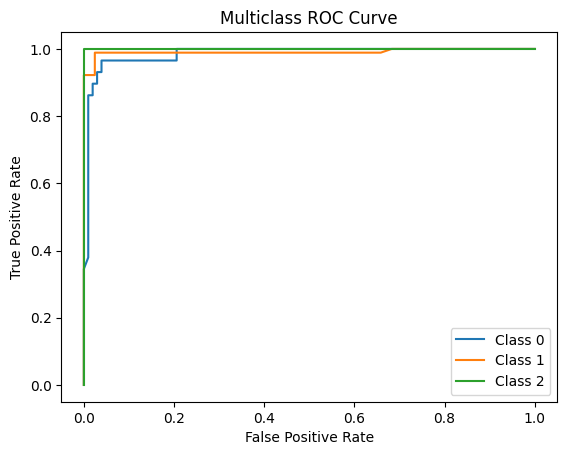

In [13]:

def evaluate_model(file_path,model=None):
    # Fit the model pipeline
    print("Fitting model pipeline...") 
    
    data_set = load_csv(file_path)
    
    data_set = feature_engineering(data_set)
    X_train, X_test, Y_train, Y_test = split_data(data_set)
    print(X_train)
    Y_train = LabelEncoder().fit_transform(Y_train)        
    class_weight_dict = class_weights(Y_train)
    
    num_attributes = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_attributes = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
    
    num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),   
    ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])          

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, num_attributes),
            ('cat', cat_pipeline, cat_attributes)
        ]
    )
    
    model = train_model(model=model,class_weight_dict=class_weight_dict)
    
        
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
        ]) 
       
    scores = cross_validation(model=model_pipeline,X_train=X_train,Y_train=Y_train,cv=5)
    print(scores)
    
    plot_roc_curve(model=model_pipeline, X_train=X_train, Y_train=Y_train)
    
    
evaluate_model(file_path='/Users/pmanthan/Desktop/Credit Score Classification Dataset.csv', model="rf")

In [14]:

def test_model(file_path,model="rf"):
    # Fit the model pipeline
    print("Fitting model pipeline...") 
    
    data_set = load_csv(file_path)
    
    data_set = feature_engineering(data_set)
    X_train, X_test, Y_train, Y_test = split_data(data_set)
    print(X_train)
    Y_train = LabelEncoder().fit_transform(Y_train)        
    class_weight_dict = class_weights(Y_train)
    
    num_attributes = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_attributes = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
    
    num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),   
    ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])          

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, num_attributes),
            ('cat', cat_pipeline, cat_attributes)
        ]
    )
    
    model = train_model(model=model,class_weight_dict=class_weight_dict)
    
        
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
        ]) 
       
    model_pipeline.fit(X_test, Y_test)
    

    Y_predict = model_pipeline.predict(X_test)
    
    sub_data = pd.DataFrame({'Survived': Y_predict})
    sub_data.to_csv('prediction.csv', index=False)
    print("Submission file created.")
    
    return Y_predict,Y_test


    
test_model(file_path='/Users/pmanthan/Desktop/Credit Score Classification Dataset.csv', model="rf")

Fitting model pipeline...
     Age  Gender  Income            Education Marital Status  \
72    51    Male  145000    Bachelor's Degree        Married   
138   40    Male  130000  High School Diploma         Single   
94    30    Male  117500      Master's Degree        Married   
12    27  Female   35000  High School Diploma         Single   
135   25  Female   55000    Bachelor's Degree         Single   
..   ...     ...     ...                  ...            ...   
114   43    Male   95000      Master's Degree         Single   
107   37  Female   77500    Bachelor's Degree        Married   
6     26  Female   40000   Associate's Degree         Single   
109   47  Female   97500            Doctorate        Married   
106   32    Male   57500   Associate's Degree         Single   

     Number of Children Home Ownership  
72                    0          Owned  
138                   0          Owned  
94                    2          Owned  
12                    0         Rented  


(array(['Average', 'High', 'High', 'High', 'High', 'High', 'Average',
        'High', 'High', 'High', 'Average', 'High', 'High', 'High', 'High',
        'High', 'Average', 'Average', 'High', 'High', 'High', 'High',
        'Average', 'Average', 'High', 'Average', 'Average', 'High', 'High',
        'High', 'High', 'High', 'Average'], dtype=object),
 131    Average
 65        High
 77        High
 28        High
 3         High
 129       High
 36     Average
 145       High
 88        High
 17        High
 90     Average
 71        High
 75        High
 84        High
 158       High
 156       High
 122    Average
 117        Low
 127       High
 103       High
 2         High
 23        High
 35     Average
 147        Low
 163       High
 68     Average
 99     Average
 1         High
 55        High
 10        High
 8         High
 91        High
 105        Low
 Name: Credit Score, dtype: object)